In [1]:
from Regression import Regression
from Franke import Franke, FrankeNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]

np.random.seed(1942)

# 1. Setup

In [2]:
x, y = np.linspace(0, 1, 201), np.linspace(0, 1, 201)
reg = Regression()
reg.generate_generic_data(x, y, FrankeNoise)

## 1.1 Franke vs Franke with 1 sigma gaussian noise

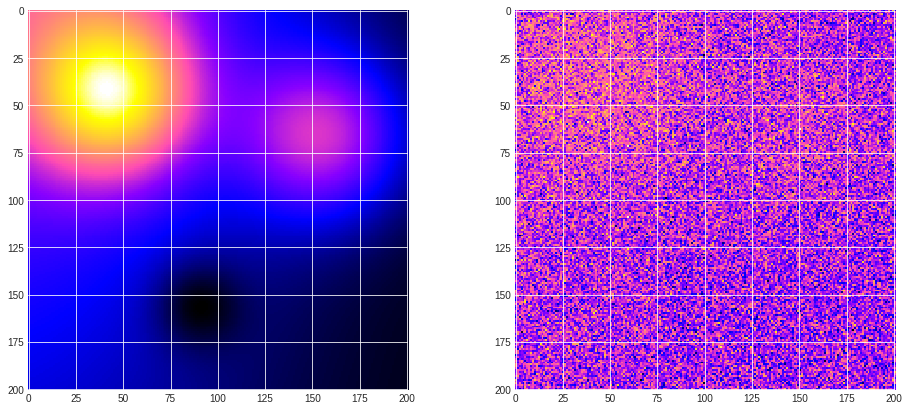

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
franke_noiseless = Franke(reg.x_mesh, reg.y_mesh)
ax1.imshow(franke_noiseless);
ax2.imshow(reg.f);

# 2. OLS Linear Regression

In [4]:
beta = reg.solveCoefficients(poly_order=5, solver="Ridge")
data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh, poly_order=5)

## 2.1 Result: 5th order polyfit on entire dataset

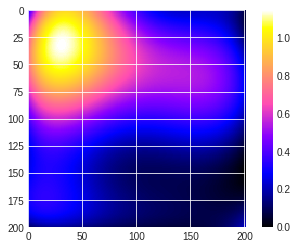

In [5]:
plt.imshow(data_pred);
plt.colorbar();

In [15]:
mse = MSE(reg.f, data_pred)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(reg.f, data_pred)
print("metrics vs noisy franke (data trained on): ", mse, rmse, rrmse, r2)

mse = MSE(franke_noiseless, data_pred)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(franke_noiseless, data_pred)
print("metrics vs noiseless franke: ", mse, rmse, rrmse, r2)

metrics vs noisy franke (data trained on):  1.0049819491630474 1.0024878798085528 2.485435088672026 0.04588674119714277
metrics vs noiseless franke:  0.0022828834643855134 0.04777952976312674 0.1184582100046966 0.9421685580070525


## 2.2 Result: Trying different polynomial degrees

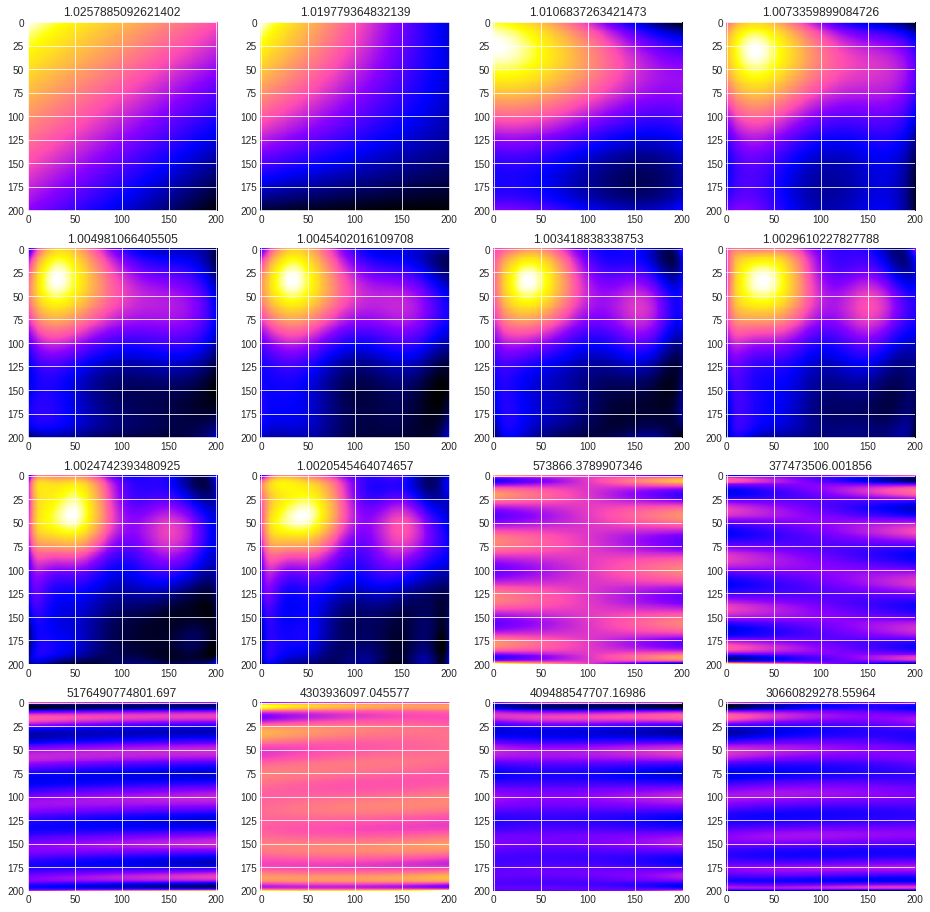

In [6]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 16
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    beta = reg.solveCoefficients(poly_order=poly_order, solver="OLS")
    data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh, poly_order=poly_order)
    ax[i//4, i%4].imshow(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, reg.f))
    err_list.append(MSE(reg.f, data_pred))
    err_list_truemodel.append(MSE(Franke(reg.x_mesh, reg.y_mesh), data_pred))    

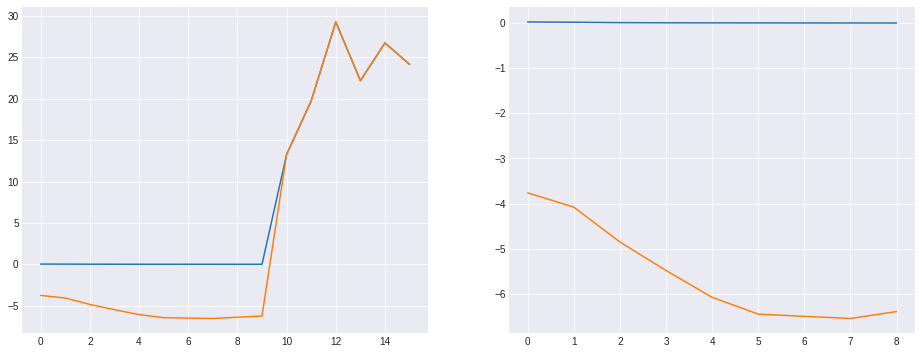

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.log(err_list));
ax1.plot(np.log(err_list_truemodel));
ax2.plot(np.log(err_list[:9]));
ax2.plot(np.log(err_list_truemodel[:9]));